In [2]:
import pandas as pd
import helpers
import get_groups_data
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats

In [4]:
# load data from csv file to dataframes
RB_breweries = pd.read_csv('./data/RateBeer/breweries.csv')
RB_beers = pd.read_csv('./data/RateBeer/beers.csv')
RB_users = pd.read_csv('./data/RateBeer/users.csv')
RB_groups = pd.read_csv('./data/RB_groups.csv')

# parse the ratings file to dataframe without textual description
RB_ratings = helpers.parse_reviews('./data/RateBeer/ratings.txt','./data/RateBeer')

In [7]:
# convert joined column to datetime
RB_users['joined'] = pd.to_datetime(RB_users['joined'], unit='s')


In [8]:
# drop the value without joined time - as there are only 0.04 % of such user
RB_users_validated = RB_users.dropna(subset='joined').copy()

# change Nan values to undefined label - as removing them from dataset will result in big information loss
RB_users_validated = RB_users_validated.fillna('Undefined')

In [9]:
# removing columns with more than 90% of missing values
RB_beers_validated = RB_beers.drop(['zscore', 'avg_matched_valid_ratings'], axis=1).copy()

# removing beers that have 0 reviews
RB_beers_validated = RB_beers_validated[RB_beers_validated['nbr_ratings'] > 0]

# dropping beers with NaN values in columns 'avg', 'abv', 'avg_computes' as there are less than 10% of them
RB_beers_validated = RB_beers_validated.dropna(subset=['avg', 'abv', 'avg_computed'])

# encode remaining Nans in overall_score and style_score with 
RB_beers_validated = RB_beers_validated.fillna(-1)

In [10]:
# dropping row with missing values as there are only ~2.5% of them
RB_ratings_validated = RB_ratings.dropna().copy()

In [14]:
RB_groups_validated = RB_groups.drop(columns='Unnamed: 0')

In [17]:
# merge beers df with location of brewery that brewed it
RB_beers_with_brewery_location = RB_beers_validated.merge(RB_breweries[['location', 'id']], left_on='brewery_id', right_on='id', how='left')

# print columns of resulting df with percentage of missing values in each
print(RB_beers_with_brewery_location.isna().mean())

beer_id                      0.0
beer_name                    0.0
brewery_id                   0.0
brewery_name                 0.0
style                        0.0
nbr_ratings                  0.0
overall_score                0.0
style_score                  0.0
avg                          0.0
abv                          0.0
avg_computed                 0.0
nbr_matched_valid_ratings    0.0
location                     0.0
id                           0.0
dtype: float64


In [18]:
RB_ratings_with_groups = RB_ratings_validated.merge(RB_groups_validated,
                                                    left_on=['brewery_name', RB_ratings_validated['date'].apply(lambda x: x.year)],
                                                    right_on=['brewery_name', 'year'],
                                                    how='left')

# replace name of group for other beers
RB_ratings_with_groups = RB_ratings_with_groups.fillna('Other')

# print columns of resulting df with percentage of missing values in each
print(RB_ratings_with_groups.isna().mean())

beer_name       0.0
beer_id         0.0
brewery_name    0.0
brewery_id      0.0
style           0.0
abv             0.0
date            0.0
user_name       0.0
user_id         0.0
appearance      0.0
aroma           0.0
palate          0.0
taste           0.0
overall         0.0
rating          0.0
year            0.0
group           0.0
main_group      0.0
dtype: float64


In [19]:
# merge ratings_group df with information about users
RB_ratings_with_groups_and_users = RB_ratings_with_groups.merge(RB_users_validated[['joined', 'location', 'nbr_ratings', 'user_id']], on='user_id')
RB_ratings_with_groups_and_users = RB_ratings_with_groups_and_users.rename(columns={
    'nbr_ratings': 'total_user_nbr_ratings',
    'location': 'user_location',
    'joined': 'user_joined'
    })

# print columns of resulting df with percentage of missing values in each
print(RB_ratings_with_groups_and_users.isna().mean())

beer_name                 0.0
beer_id                   0.0
brewery_name              0.0
brewery_id                0.0
style                     0.0
abv                       0.0
date                      0.0
user_name                 0.0
user_id                   0.0
appearance                0.0
aroma                     0.0
palate                    0.0
taste                     0.0
overall                   0.0
rating                    0.0
year                      0.0
group                     0.0
main_group                0.0
user_joined               0.0
user_location             0.0
total_user_nbr_ratings    0.0
dtype: float64


In [20]:
# inner merge breweries with groups that own it
# equivalent to selecting only InBev breweries from dataset
RB_group_breweries = RB_breweries.merge(RB_groups_validated, left_on='name', right_on='brewery_name') 

In [21]:
display(RB_beers_with_brewery_location)

,beer_id,beer_name,brewery_id,brewery_name,style,nbr_ratings,overall_score,style_score,avg,abv,avg_computed,nbr_matched_valid_ratings,location,id
0,410549,33 Export (Gabon),3198,Sobraga,Pale Lager,1,-1.0,-1.0,2.72,5.0,2.000000,0,Gabon,3198
1,105273,Castel Beer (Gabon),3198,Sobraga,Pale Lager,10,5.0,58.0,2.18,5.2,1.910000,0,Gabon,3198
2,19445,Régab,3198,Sobraga,Pale Lager,27,1.0,22.0,1.83,4.5,1.811111,0,Gabon,3198
3,155699,Ards Bally Black Stout,13538,Ards Brewing Co.,Stout,6,-1.0,-1.0,3.18,4.6,3.866667,6,Northern Ireland,13538
4,239097,Ards Belfast 366,13538,Ards Brewing Co.,Golden Ale/Blond Ale,1,-1.0,-1.0,2.79,4.2,3.000000,0,Northern Ireland,13538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359009,153089,Stela Double Malt Strong Beer,1107,Stefani & Co,Imperial Pils/Strong Pale Lager,7,-1.0,-1.0,2.62,6.0,2.457143,0,Albania,1107
359010,153086,Stela Krudo,1107,Stefani & Co,Wheat Ale,1,-1.0,-1.0,2.77,4.8,2.900000,0,Albania,1107
359011,220722,Stela Pils,1107,Stefani & Co,Pale Lager,18,2.0,33.0,1.93,5.0,1.727778,0,Albania,1107
359012,287791,Stela Pils 4%,1107,Stefani & Co,Pilsener,17,3.0,2.0,1.92,4.0,1.705882,0,Albania,1107


In [24]:
display(RB_ratings_with_groups_and_users)
print(RB_ratings_with_groups_and_users.columns)

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,...,palate,taste,overall,rating,year,group,main_group,user_joined,user_location,total_user_nbr_ratings
0,Slumbrew Sittin on Hop of the World,220923,Somerville Brewing Company &#40;Slumbrew&#41;,13696,India Pale Ale (IPA),6.80,2015-11-14 11:00:00,corby112,55936,4,...,3,5,10,2.8,2015,Other,Other,2007-06-15 10:00:00,"United States, Pennsylvania",2235
1,Wachusett Belgian Style White,141817,Wachusett Brewing Company,1164,Witbier,4.47,2011-07-04 10:00:00,corby112,55936,2,...,4,8,16,3.8,2011,Other,Other,2007-06-15 10:00:00,"United States, Pennsylvania",2235
2,Wachusett Larry Imperial IPA,115369,Wachusett Brewing Company,1164,Imperial IPA,8.50,2011-04-09 10:00:00,corby112,55936,4,...,4,7,14,3.6,2011,Other,Other,2007-06-15 10:00:00,"United States, Pennsylvania",2235
3,Boaks Iced Monster Mash,146519,Boaks,11017,Imperial Stout,13.00,2011-11-29 11:00:00,corby112,55936,4,...,2,3,8,2.3,2011,Other,Other,2007-06-15 10:00:00,"United States, Pennsylvania",2235
4,Cape May Saison,185002,Cape May Brewing Company,13128,Saison,6.20,2015-12-01 11:00:00,corby112,55936,4,...,4,8,15,3.8,2015,Other,Other,2007-06-15 10:00:00,"United States, Pennsylvania",2235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6947469,Haffenreffer Private Stock Malt Liquor,8699,Private Stock Brewing Company - Haffenreffer &...,12419,Malt Liquor,6.87,2006-04-03 10:00:00,40ozItalian,35556,5,...,5,10,20,5.0,2006,Other,Other,2006-04-03 10:00:00,Undefined,2
6947470,Rapscallion Honey Ale,111058,Rapscallion,10898,American Pale Ale,4.50,2013-06-30 10:00:00,emchandl,266579,4,...,4,5,11,2.9,2013,Other,Other,2013-06-30 10:00:00,Undefined,1
6947471,RiverWalk Uncle Bobs Bitter,194516,RiverWalk Brewing Company,15704,Bitter,4.50,2013-06-24 10:00:00,lzdude,114477,4,...,4,8,16,3.8,2013,Other,Other,2010-10-01 10:00:00,"United States, Massachusetts",1
6947472,Slumbrew Attic and Eaves,189895,Somerville Brewing Company &#40;Slumbrew&#41;,13696,Brown Ale,7.50,2015-06-25 10:00:00,seegs,346821,3,...,4,7,16,3.9,2015,Other,Other,2014-11-30 11:00:00,Undefined,1


Index(['beer_name', 'beer_id', 'brewery_name', 'brewery_id', 'style', 'abv',
       'date', 'user_name', 'user_id', 'appearance', 'aroma', 'palate',
       'taste', 'overall', 'rating', 'year', 'group', 'main_group',
       'user_joined', 'user_location', 'total_user_nbr_ratings'],
      dtype='object')


In [23]:
display(RB_group_breweries)

,id,location,name,nbr_beers,year,brewery_name,group,main_group
0,547,Singapore,Singapore Brewery (Asia Pacific Breweries-Hein...,17,2000,Singapore Brewery (Asia Pacific Breweries-Hein...,Heineken,Heineken
1,547,Singapore,Singapore Brewery (Asia Pacific Breweries-Hein...,17,2001,Singapore Brewery (Asia Pacific Breweries-Hein...,Heineken,Heineken
2,547,Singapore,Singapore Brewery (Asia Pacific Breweries-Hein...,17,2002,Singapore Brewery (Asia Pacific Breweries-Hein...,Heineken,Heineken
3,547,Singapore,Singapore Brewery (Asia Pacific Breweries-Hein...,17,2003,Singapore Brewery (Asia Pacific Breweries-Hein...,Heineken,Heineken
4,547,Singapore,Singapore Brewery (Asia Pacific Breweries-Hein...,17,2004,Singapore Brewery (Asia Pacific Breweries-Hein...,Heineken,Heineken
...,...,...,...,...,...,...,...,...
3791,1521,Kenya,Kenya Breweries (EABL/East African Breweries -...,13,2012,Kenya Breweries (EABL/East African Breweries -...,Diageo,Diageo
3792,1521,Kenya,Kenya Breweries (EABL/East African Breweries -...,13,2013,Kenya Breweries (EABL/East African Breweries -...,Diageo,Diageo
3793,1521,Kenya,Kenya Breweries (EABL/East African Breweries -...,13,2014,Kenya Breweries (EABL/East African Breweries -...,Diageo,Diageo
3794,1521,Kenya,Kenya Breweries (EABL/East African Breweries -...,13,2015,Kenya Breweries (EABL/East African Breweries -...,Diageo,Diageo


In [129]:
years_comparison = RB_group_breweries.groupby(['year', 'group']).nunique().loc[: , ['location', 'brewery_name']]
display(years_comparison)

location  brewery_name
year group                              
2000 AB                  1             1
     Ambev               3             3
     Carslberg          27            56
     Coors               2             4
     Diageo             10            11
...                    ...           ...
2016 ABInBev            38            67
     Carslberg          29            62
     Diageo              9             9
     Heineken           53            88
     MolsonCoors        14            23

[131 rows x 2 columns]

Text(0.5, 1.0, 'Number of breweries owned by group')

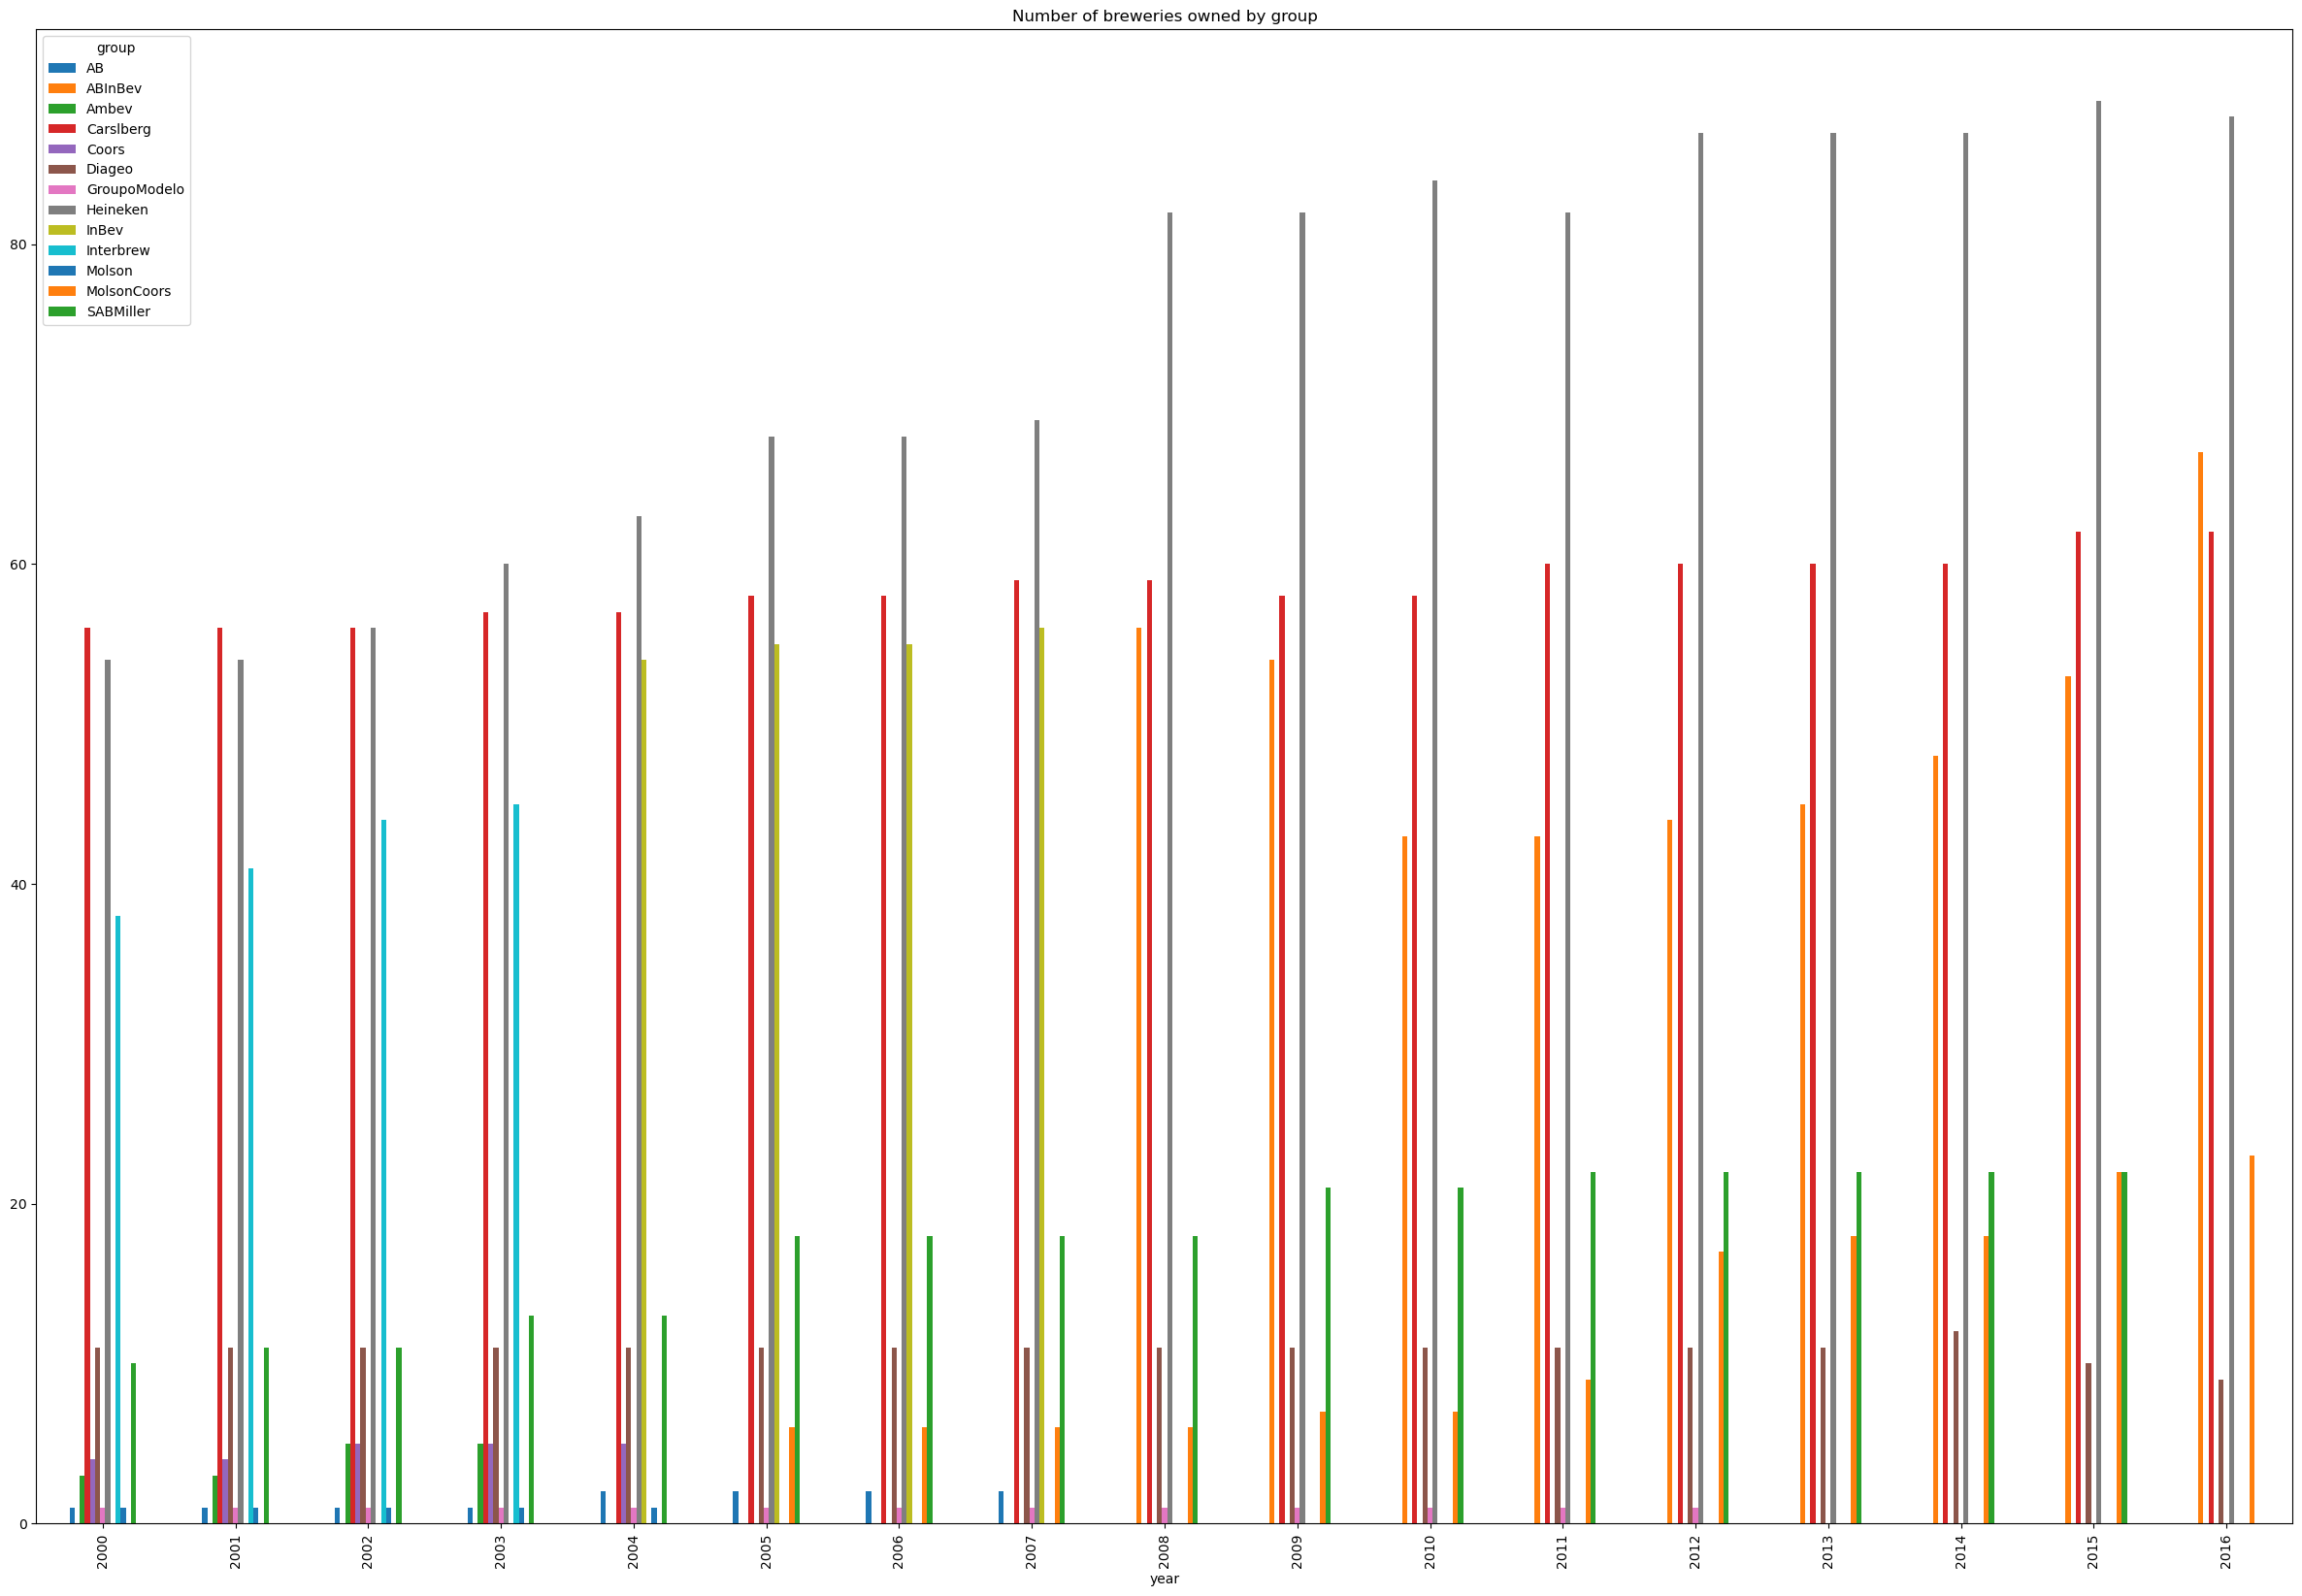

In [85]:
years_comparison['brewery_name'].unstack().plot(kind='bar')
plt.rcParams["figure.figsize"] = (30,20)
plt.title('Number of breweries owned by group')

# sns.catplot(data=years_comparison, x='year', y='brewery_name', hue='main_group', color='#eb9e34', kind='bar')
# plt.xticks(rotation=90)
# plt.show()

,beer_name
main_group,
Carslberg,47539
Diageo,23060
Heineken,85857
InBev,197930
MolsonCoors,43147
Other,6549941


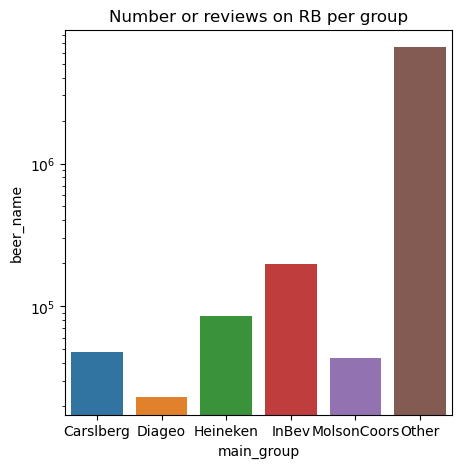

In [112]:
number_of_groups_reviews = (RB_ratings_with_groups_and_users.groupby('main_group').count()['beer_name']).to_frame()
display(number_of_groups_reviews)
sns.barplot(number_of_groups_reviews, x=number_of_groups_reviews.index, y='beer_name')
plt.rcParams["figure.figsize"] = (5,4)
plt.title('Number or reviews on RB per group')
plt.yscale('log')

In [93]:
display(RB_ratings_with_groups_and_users[RB_ratings_with_groups_and_users['year'] == 2016].groupby('main_group').count()['beer_name'] / len(RB_ratings_with_groups_and_users[RB_ratings_with_groups_and_users['year'] == 2016].index))

main_group
Carslberg      0.005110
Diageo         0.001833
Heineken       0.011919
InBev          0.012696
MolsonCoors    0.006250
Other          0.962192
Name: beer_name, dtype: float64

In [52]:
financial_results_df = pd.read_csv('./data/finacial_results(USD).csv', header=1, index_col=0)
display(financial_results_df)

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
Molson-Coors,2414415000,2429462000,3776322000,4000113000,4305816000,5506906000,5844985000,6190592000,4774300000,3032400000,3254400000,3515700000,3916500000,4206100000,4146300000,3567500000,4885000000
AB inBev,5317204000,6499492000,7341600000,8875440000,11652480000,13754080000,17566560000,21067800000,22542800000,33862000000,36297000000,39046000000,39758000000,43195000000,47063000000,43604000000,45517000000
Heineken,7620580000,8155070000,10807650000,11661300000,12521520000,11412960000,13933920000,16417700000,20046600000,21022430000,21618220000,22088670000,24265560000,26500140000,23300970000,22356990000,21831600000
Carlsberg,3206250000,4061442000,4976160000,5817168000,6639972000,6049473000,7264611000,8815750000,11329416000,11460919000,10689612000,11075274000,11831304000,12245568000,10578984000,9313038000,8828574000
Asahi,9862151289,8406746031,8901296842,10333239988,10507401636,8698676620,8465451184,9061462715,10967099900,10293897722,11458920044,11972681215,10644621421,8796864608,7866032540,8092438679,8349863201


In [145]:
group_year_countries = dict()
for year in range(2000, 2017):
    group_year_countries[year] = dict()
    for group in RB_group_breweries['group'].unique():
        group_df = (RB_group_breweries[(RB_group_breweries['year'] == year) & (RB_group_breweries['group'] == group)].loc[:, ['brewery_name', 'location']])
        group_df = group_df.groupby('location').count()
        if len(group_df) > 0:
            group_year_countries[year][group] = list(group_df.itertuples(index=True, name=None))

print(group_year_countries)

{2000: {'Heineken': [('Bahamas', 1), ('Belarus', 1), ('Belgium', 1), ('Brazil', 1), ('Bulgaria', 1), ('Burundi', 1), ('China', 3), ('Congo', 1), ('Croatia', 1), ('Czech Republic', 1), ('Dem Rep of Congo', 1), ('England', 4), ('France', 3), ('Ghana', 1), ('Greece', 1), ('Hungary', 1), ('India', 1), ('Indonesia', 1), ('Ireland', 1), ('Italy', 1), ('Myanmar', 1), ('Netherlands', 2), ('Nigeria', 1), ('Papua New Guinea', 1), ('Poland', 5), ('Reunion', 1), ('Romania', 1), ('Rwanda', 1), ('Saint Lucia', 1), ('Scotland', 1), ('Serbia', 1), ('Sierra Leone', 1), ('Singapore', 1), ('Slovak Republic', 3), ('South Africa', 1), ('Spain', 2), ('Sri Lanka', 1), ('Switzerland', 1), ('Vietnam', 1)], 'AB': [('United States, Missouri', 1)], 'Carslberg': [('Azerbaijan', 1), ('Belarus', 1), ('Bulgaria', 2), ('China', 6), ('Croatia', 1), ('Denmark', 3), ('Estonia', 1), ('Finland', 2), ('France', 1), ('Germany', 1), ('Italy', 1), ('Kazakhstan', 1), ('Latvia', 1), ('Lithuania', 2), ('Malawi', 1), ('Malaysia', 

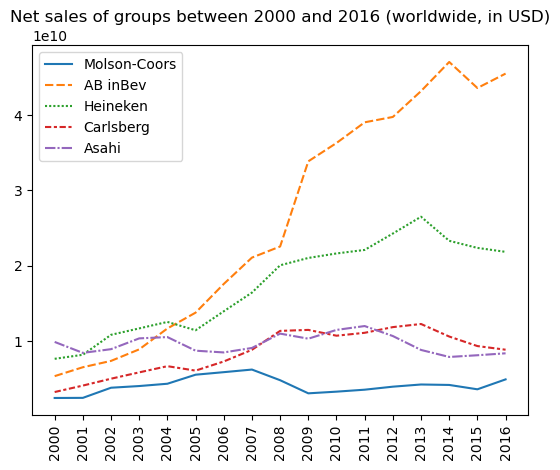

In [51]:
sns.lineplot(data=financial_results_df.T)
plt.title('Net sales of groups between 2000 and 2016 (worldwide, in USD)')
plt.xticks(rotation=90)
plt.show()

In [116]:
scipy.stats.pearsonr(
    RB_ratings_with_groups_and_users[RB_ratings_with_groups_and_users['main_group']=='InBev'].groupby('year').count()['beer_name'],
    financial_results_df.loc['AB inBev']
)

PearsonRResult(statistic=0.6798729012830462, pvalue=0.0026764546190200062)

In [128]:
scipy.stats.pearsonr(
    RB_ratings_with_groups_and_users[RB_ratings_with_groups_and_users['main_group']=='Carslberg'].groupby('year').count()['beer_name'],
    financial_results_df.loc['Carlsberg']
)

PearsonRResult(statistic=0.8638846020791668, pvalue=7.840084743046798e-06)

In [121]:
scipy.stats.pearsonr(
    RB_ratings_with_groups_and_users[RB_ratings_with_groups_and_users['main_group']=='Heineken'].groupby('year').count()['beer_name'],
    financial_results_df.loc['Heineken']
)

PearsonRResult(statistic=0.8624146969708686, pvalue=8.459972277764e-06)

In [122]:
scipy.stats.pearsonr(
    RB_ratings_with_groups_and_users[RB_ratings_with_groups_and_users['main_group']=='MolsonCoors'].groupby('year').count()['beer_name'],
    financial_results_df.loc['Molson-Coors']
)

PearsonRResult(statistic=0.28367774396111267, pvalue=0.2698508528192913)